## Clustering avec l'algorithme de KMeans

### Importation de bibliothèques necessaires

In [14]:
# librairies standards
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris

# Fonctions pour scikit-learn
from sklearn.cluster import KMeans, DBSCAN

# Fonctions pour silhouette
from sklearn.metrics import silhouette_score as sc



### Ruspiri dataset

In [9]:
# load du dataset
df = pd.read_csv("ruspini.csv", sep=",")

# Affichage et description statistique du dataset
df.head()
df.describe()

,Unnamed: 0,x,y
count,75.000000,75.00000,75.000000
mean,38.000000,54.88000,92.026667
std,21.794495,30.50253,48.702620
min,1.000000,4.00000,4.000000
25%,19.500000,31.50000,56.500000
50%,38.000000,52.00000,96.000000
75%,56.500000,76.50000,141.500000
max,75.000000,117.00000,156.000000


### Visualisation des données

Text(0.5, 1.0, 'Representation 2D du dataset Raspiri')

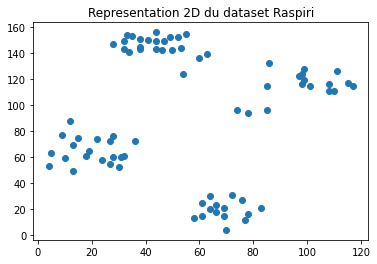

In [10]:
x = df["x"]
y = df["y"]

plt.scatter(x, y)
plt.title("Representation 2D du dataset Raspiri")

**commentaire:** A partir du nuage de point, on observe qu'il est possible de former 4 cluster.

## A - Algorithme KMeans

### Implementation de l'algo KMeans

In [15]:
# Thanks to Mai Quyen Pham
def Kmeans(data, nb_clusters):
    
    # Stopping criterion for the algorithm
    stop_crit = 1e-7
    
    # Select some initial centroïds
    pos = rnd.sample(range(np.shape(data)[0]),nb_clusters)
    centers = data[pos,:]
    
    # Initialize the algorithm
    distances = np.zeros((data.shape[0], centers.shape[0]))
    error = 10
    # Run the algorithm
    while error > stop_crit:
        # Finds the data in each cluster
        for i in range(nb_clusters):
            distances[:,i] = np.linalg.norm(data-centers[i], axis=1)
        clusters = np.argmin(distances, axis=1)
        centers_old = centers.copy()
        
        # Estimates the centroids
        for i in range(nb_clusters):
            centers[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(centers - centers_old)  
        
    return centers, clusters

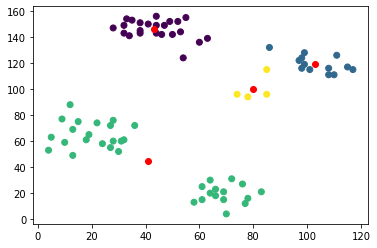

In [16]:
# Run K-means onto the Ruspini dataset
data = np.array(df)[:,[1,2]]
centers,clusters = Kmeans(data,4)

# plot the results
plt.scatter(df['x'], df['y'],c=clusters)
plt.scatter(centers[:,0],centers[:,1],c="red")

__Comment__: Since we didn't set a proper initialization, the K-means method is unstable. Sometimes it retrieves the correct clusters, and sometimes not.

### Le modele Scikit-learn
> les paramètres **init** (methode d'initialisation des centroids), **n_init** (nombre de repetition de l'algorithme), et **max_iter** (nombre max d'iterations pour chaque repetition de l'algo) sont definie par defaut.

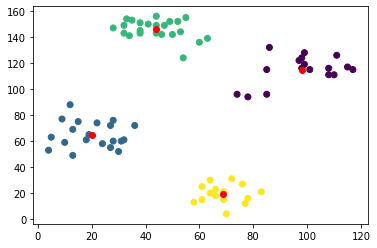

In [17]:
model = KMeans(n_clusters = 4, init = "k-means++", n_init = 1, max_iter = 300)

# Entrainement du modele
model.fit(data)

# Centroids finaux
centers = model.cluster_centers_

# Label de chaque point du dataset
labels = model.labels_

# Affiche des classes et des centroids
plt.scatter(x, y, c=labels)
plt.scatter(centers[:,0], centers[0:,1], c="r")

En executant l'algorithme de KMeans avec la methode d'initialisation des centroids **KMeans++** et un nombre d'initialisation **n_init = 1**, on constate après plus repetion on obtient toujours le même resultat.

### Fonction cout 
> inertia : somme des distance entre chaque point et son centroid

In [18]:
cout = model.inertia_
cout

12881.051236146632

### Comment trouver le bon nombre de cluster pour le modele s'il est inconnu ?


### 1. Silhouette method

> étudier la distance de séparation entre les clusters résultants. Pour un cluster donnée, il mesure la distance entre chaque de ce dernier et tout les points des clusters voisins. Prends ces valeur entre -1 et 1.

- **1** : le point est très eloigné du cluster voisin
- **0** : le point est très proche du cluster voisin
- **-1**: le point à été assigné au mauvais cluster

l'analyse est ambigue lorsqu'il s'agit de choisir entre 2 et 4 clusters

In [19]:
score = []
nb_clusters = range(2, 8)

# Pour chaque cluster il calcule le coefficient de silhouette
for i in nb_clusters:
    model = KMeans(n_clusters = i)
    model.fit(data)
    label = model.labels_
    score.append(sc(data, label))
    print("coef silhouette pour i (cluster) = " +str(i)+" est"+str(sc(data, label)))
print("le max des coef est :", max(score))

coef silhouette pour i (cluster) = 2 est0.5827264208152947
coef silhouette pour i (cluster) = 3 est0.6327047140348644
coef silhouette pour i (cluster) = 4 est0.7376569908806615
coef silhouette pour i (cluster) = 5 est0.7019241413569157
coef silhouette pour i (cluster) = 6 est0.5939992676136585
coef silhouette pour i (cluster) = 7 est0.4992790879342552
le max des coef est : 0.7376569908806615


Plus le coefficient de silhouette est proche de 1 moins la fonction cout **(inertia_)** est elevé.
A partir ces deux observations dessus, on observe que le coef max est atteint pour k = 4 cluster.
Alors le nombre de cluster optimale pour notre modele est 4.

Text(0, 0.5, 'coefficient de silhouette')

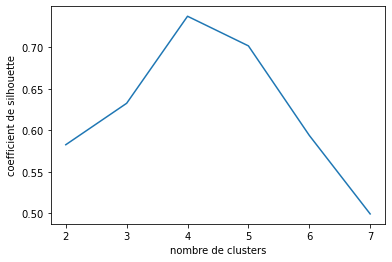

In [20]:
plt.plot(nb_clusters, score)
plt.xlabel("nombre de clusters")
plt.ylabel("coefficient de silhouette")

In [21]:
max(score)

0.7376569908806615

### 2. Elbow method 
> consiste à detecter une zone de **coude** dans la minimisation du cout(inertia_)

In [23]:
# Tableaux contenant la liste des cout pour un nombre i de clusters
cout = []
# Nombre de clusters
nb_clusters = range(2, 20)

for i in nb_clusters:
    model = KMeans(n_clusters = i)
    model.fit(data)
    cout.append(model.inertia_)
    

Text(0, 0.5, 'couts du modele')

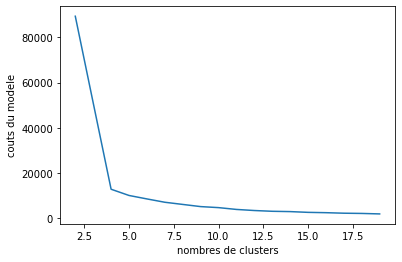

In [24]:
plt.plot(nb_clusters, cout)
plt.xlabel("nombres de clusters")
plt.ylabel("couts du modele")

A partir du graphique, on observe une zone de coude pour un nombre de cluster égale à 4.

## B -  Algorithme DBSCAN

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density

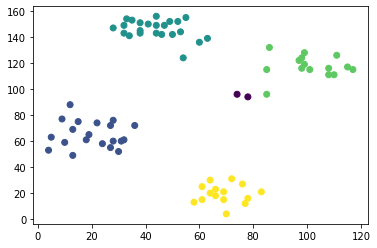

In [25]:
#le modele
model = DBSCAN(eps=20, min_samples=5)
#entrainement
model.fit(data)

# les classes
labels = model.labels_
np.unique(labels)
pd.value_counts(labels)

#plots des resultats

plt.scatter(x, y, c=labels)

**commentaire:** on constate après plusieurs executions de l'algorithme que les performances depandent beaucoup du choix des valeurs des paramètre **eps** et **min_samples**. Il y a également certains points qui n'appartiennes à aucun cluster.

## Iris dataset

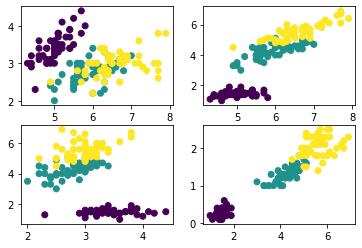

In [26]:
iris = load_iris()

# features
X = iris.data
# Targets
Y = iris.target

# Description du dataset
#data.DESCR

# plot des points en 2D
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1],c=Y)

plt.subplot(2,2,2)
plt.scatter(X[:,0], X[:,2],c=Y)

plt.subplot(2,2,3)
plt.scatter(X[:,1], X[:,2],c=Y)

plt.subplot(2,2,4)
plt.scatter(X[:,2], X[:,3],c=Y)

**Commentaire:** la representation de certaines dimensions du dataset montre qu'il est constitué de 3.

Verifions si l'algorithme de KMeans arriveras à les distinguè correcetement avec la methode **Silhouette**.

In [27]:
score = []

# K dois commencer à deux
k = range(2, 8)

for i in k:
    modele = KMeans(n_clusters = i).fit(X) 
    labels = modele.labels_ #Extraction des labels
    silhouette_avg = sc(X, labels) # Calcule du coefficient
    score.append(silhouette_avg)
    print("le coef de silhouette pour ", i ," clusters est :", silhouette_avg)

le coef de silhouette pour  2  clusters est : 0.681046169211746
le coef de silhouette pour  3  clusters est : 0.5528190123564091
le coef de silhouette pour  4  clusters est : 0.49745518901737446
le coef de silhouette pour  5  clusters est : 0.4887488870931048
le coef de silhouette pour  6  clusters est : 0.3678464984712235
le coef de silhouette pour  7  clusters est : 0.3543964478588638


**Commentaire:** l'algorithme KMeans trouve qu'il existe que 2 clusters dans le dataset. Ce qui est incorrect.